## New Construction Database

Let us try to create a visualization of new construction in Philadelphia.

In [2]:
import requests
import pandas as pd
import numpy as np
from pandas import json_normalize
pd.set_option("display.max.columns", None)
np.set_printoptions(suppress=True)

base_url = "https://phl.carto.com/api/v2/sql"
query = """
SELECT * FROM permits
"""

params = {
    "q":query
}

results = requests.get(base_url, params)

data = results.json()

permits = pd.DataFrame(data['rows'])

permits.head()

,cartodb_id,the_geom,the_geom_webmercator,objectid,permitnumber,addressobjectid,parcel_id_num,permittype,permitdescription,commercialorresidential,typeofwork,approvedscopeofwork,permitissuedate,status,applicanttype,contractorname,contractoraddress1,contractoraddress2,contractorcity,contractorstate,contractorzip,mostrecentinsp,opa_account_num,address,unit_type,unit_num,zip,censustract,council_district,opa_owner,systemofrecord,geocode_x,geocode_y,posse_jobid,usecategories,occupancytype,numberofunits,certificateofoccupancyrequired,certificateofoccupancydate,permitcompleteddate
0,1,0101000020E6100000B952A8FFC3CA52C0691B02E152FA...,0101000020110F00000D791ECB91EB5FC1E390D20A9B89...,1,CP-2022-001232,133893300,420049,Building,Commercial Building Permit,Commercial,Addition and/or Alteration,Repair concrete spalls on columns and balcony ...,2022-04-04T04:00:00Z,Amendment Application Incomplete,Professional / Tradesperson,Pullman SST,Pullman SST\r\n179 PENNSYLVANIA AVE\r\nMALVERN...,None,None,None,None,2024-04-01T18:40:05Z,883720300,1700-20 BENJAMIN FRANKLIN PKWY,None,None,19103-2735,3,5,WINDSOR ASSOC LTD,ECLIPSE,2.692183e+06,237282.350242,450683930,None,R-1 Residential (Transient),1.0,N,None,None
1,2,0101000020E61000007F05CEE474C552C0C81EB146AA04...,0101000020110F0000AACA8D378DE25FC15CD034FF1195...,2,GM-2024-008835,130572974,367650,General Permit Minor,General Permit Minor,Residential,EZ Roof Covering Replacement,For minor construction work at the subject pro...,2024-10-02T04:00:00Z,Issued,Professional / Tradesperson,None,None,None,None,None,None,2024-10-17T12:28:01Z,531269600,6005 FRONTENAC ST,None,None,19149-3238,311.02,9,ADEJUMO TAIWO,ECLIPSE,2.714541e+06,267390.815915,796904146,None,None,NaN,None,None,None
2,3,0101000020E6100000159ED4D07BC752C09096F2A452FC...,0101000020110F0000D7E17FA8FEE55FC12327DC1FD28B...,3,PP-2020-013920,128407555,530784,Plumbing,Plumbing Permit,Residential,New Construction or Additions,ERECTION OF AN ATTACHED STRUCTURE FOR USE AS T...,2022-06-21T04:00:00Z,Completed,Professional / Tradesperson,UNITED STATES PLUMBING LLC,UNITED STATES PLUMBING LLC\r\n1651OLD GRADYVIL...,None,None,None,None,2023-06-12T14:27:41Z,None,2001 BEACH ST,None,None,19125,378,1,None,ECLIPSE,2.706384e+06,243393.523151,291562199,None,None,NaN,None,None,2021-11-03T21:41:00Z
3,4,0101000020E6100000A2A810F125CA52C01A17C25156F6...,0101000020110F00008D86555185EA5FC1C44D888E3085...,4,PP-2021-003762,15415193,467000,Plumbing,Plumbing Permit,Residential,New Construction or Additions,FOR THE ERECTION OF AN ATTACHED THREE STORY ST...,2021-08-03T04:00:00Z,Completed,Professional / Tradesperson,FERKO PLUMBING & HEATING CO INC,FERKO PLUMBING & HEATING CO INC\r\n2642 Mercer...,None,None,None,None,2022-01-19T13:37:09Z,393021010,714 DUDLEY ST,None,None,19148-2424,41.01,1,"TRUSCHEL JACKSON P, TRUSCHEL JESSICA",ECLIPSE,2.695220e+06,226020.872360,324614701,None,None,NaN,None,None,2022-01-19T19:00:26Z
4,5,0101000020E6100000033321CF3DCB52C0D4A44884C1F8...,0101000020110F0000726C62B360EC5FC194522B63DE87...,5,RP-2022-010840,15383756,202367,Residential Building,Residential Building Permit,Residential,Addition and/or Alteration,For the erection of an addition to an existing...,2023-01-19T05:00:00Z,Completed,Professional / Tradesperson,DETAIL EXCHANGE LLC,DETAIL EXCHANGE LLC\r\n136 PITMAN DOWNER RD\r\...,None,None,None,None,2023-09-08T18:09:18Z,301082700,2006 PEMBERTON ST,None,None,19146-1319,14,2,KUKLICK STANTON,ECLIPSE,2.690230e+06,232761.462460,524387987,None,R-3 Residential (1 or 2 Dwellings),NaN,N,None,2023-09-11T15:28:07Z


First, I am going to convert the parcel_id_numver into numeric. I am also going to remove all permits that are still pending, i.e. work for it hasn't been closed.

In [3]:
permits = permits[permits['permitcompleteddate'].notna()]
permits['parcel_id_num'] = pd.to_numeric(permits['parcel_id_num'], errors='coerce')
permits = permits[permits['parcel_id_num'].notna()]
permits['parcel_id_num'] = permits['parcel_id_num'].astype(int)

From the various permit description it seems like as long as I filter for Zoning, Building, or Use, I should be able to get the units I want. So lets do that.

In [4]:
permits['permitdescription'].value_counts()

permitdescription
PLUMBING PERMIT                 136280
ALTERATION PERMIT                89707
ELECTRICAL PERMIT                78209
Plumbing Permit                  66054
Electrical Permit                45246
MECHANICAL PERMIT                41019
ZONING/USE PERMIT                30114
USE PERMIT                       27760
Residential Building Permit      22295
Mechanical / Fuel Gas Permit     21161
SUPPRESSION PERMIT               20650
ZONING PERMIT                    19849
General Permit Minor             17600
ADMINISTRATIVE PERMIT            17355
Commercial Building Permit       12420
DEMOLITION PERMIT                12342
Fire Suppression Permit          11730
NEW CONSTRUCTION PERMIT          10775
OPERATIONS PERMIT                 6765
ADDITION PERMIT                   5928
Zoning Permit                     5482
SIGN PERMIT                       4120
FAST FORM BUILDING PERMIT         3679
Demolition Permit                 3272
General Permit                    3034
Adminis

My first layer filtering. I get all permits that have something to do with Building, Construction, Zoning, or Use in their permit description.

In [5]:
newcons = permits[permits['permitdescription'].str.upper().str.contains('BUILDING|CONSTRUCTION|ZONING|USE')]
#remove all commerical buildings
newcons = newcons[newcons['commercialorresidential'] != "Commercial"]
newcons.head()

,cartodb_id,the_geom,the_geom_webmercator,objectid,permitnumber,addressobjectid,parcel_id_num,permittype,permitdescription,commercialorresidential,typeofwork,approvedscopeofwork,permitissuedate,status,applicanttype,contractorname,contractoraddress1,contractoraddress2,contractorcity,contractorstate,contractorzip,mostrecentinsp,opa_account_num,address,unit_type,unit_num,zip,censustract,council_district,opa_owner,systemofrecord,geocode_x,geocode_y,posse_jobid,usecategories,occupancytype,numberofunits,certificateofoccupancyrequired,certificateofoccupancydate,permitcompleteddate
4,5,0101000020E6100000033321CF3DCB52C0D4A44884C1F8...,0101000020110F0000726C62B360EC5FC194522B63DE87...,5,RP-2022-010840,15383756,202367,Residential Building,Residential Building Permit,Residential,Addition and/or Alteration,For the erection of an addition to an existing...,2023-01-19T05:00:00Z,Completed,Professional / Tradesperson,DETAIL EXCHANGE LLC,DETAIL EXCHANGE LLC\r\n136 PITMAN DOWNER RD\r\...,None,None,None,None,2023-09-08T18:09:18Z,301082700,2006 PEMBERTON ST,None,None,19146-1319,14,2,KUKLICK STANTON,ECLIPSE,2.690230e+06,232761.462460,524387987,None,R-3 Residential (1 or 2 Dwellings),NaN,N,None,2023-09-11T15:28:07Z
11,12,0101000020E6100000798C30318BC952C09CAEDC2FB4F6...,0101000020110F0000647EC8757EE95FC15F3574839885...,21,RP-2022-005809,133293093,294744,Residential Building,Residential Building Permit,Residential,Addition and/or Alteration,FOR THE ERECTION OF A ROOF DECK ALONG FERNON S...,2022-07-15T04:00:00Z,Completed,Professional / Tradesperson,ELSAM CORPORATION,ELSAM CORPORATION\r\n525 S. 4th Street\r\n# 24...,None,None,None,None,2023-01-18T17:51:13Z,011207000,1618 S 2ND ST,None,None,19148-1334,27.02,1,"GREENWICH CORP, A PA CORP",ECLIPSE,2.697837e+06,227141.812422,479350122,None,R-3 Residential (1 or 2 Dwellings),NaN,N,None,2024-01-23T19:37:46Z
19,20,0101000020E6100000055D60FAFAC852C038C227042905...,0101000020110F000098BD767F89E85FC144392C979E95...,19,RP-2020-012007,132493877,281016,Residential Building,Residential Building Permit,Residential,Addition and/or Alteration,EZ PERMIT STANDARDS ALTERATIONS - For alterati...,2020-11-02T05:00:00Z,Completed,Professional / Tradesperson,SNA Renovations LLC,SNA Renovations LLC\r\n107 S 2nd Street\r\n3rd...,None,None,None,None,2021-05-19T17:02:24Z,493122900,5739 N 12TH ST,None,None,19141-4110,276,9,"TCS ANIKA ACQUISITIONS III, LLC",ECLIPSE,2.699089e+06,268338.850371,278625986,None,R-3 Residential (1 or 2 Dwellings),NaN,N,None,2021-05-21T18:51:37Z
45,46,0101000020E6100000A9E22C2540C952C01CB8123BE1FF...,0101000020110F00004D5C3EFCFEE85FC1E34AEF74C38F...,45,RP-2023-013058,130322988,203274,Residential Building,Residential Building Permit,Residential,Addition and/or Alteration,FOR ALTERATIONS AND CHANGE IN OCCUPANCY (CONVE...,2024-04-23T04:00:00Z,Completed,Professional / Tradesperson,kray construction llc,kray construction llc\r\n16 folcroft avenue\r\...,None,None,None,None,2025-01-08T13:29:28Z,372145200,3105 N 9TH ST,None,None,19133-2030,175,5,SUMAYYAH LLC,ECLIPSE,2.698351e+06,253282.652908,669281077,None,R-3 Residential (1 or 2 Dwellings),NaN,Y,2025-01-08T16:31:04Z,2025-01-08T16:30:55Z
47,48,0101000020E61000006F465904F5C552C0CC9A9C4E8000...,0101000020110F0000803EE1D866E35FC1701568D37390...,46,991612,136268334,105581,Residential Building,Residential Building Permit,Residential,Addition and/or Alteration,MAKE SAFE PERMIT TO ADDRESS L&I UNSAFE CASE #6...,2019-08-16T16:01:00Z,Expired,Owner,A1 MECHANICAL INC,A1 MECHANICAL INC\r\n1912 LANSING STREET\r\nPH...,None,None,None,None,2020-05-06T11:35:22Z,453166200,3935 ARCADIA ST,None,None,19124-5008,382,1,OLMEDA DANIEL,ECLIPSE,2.712708e+06,255479.802221,217645672,None,R-3 Residential (1 or 2 Dwellings),NaN,N,None,2022-05-10T15:02:38Z


Okay but this still contains a lot of observations of alterations and such which is not needed. Hence, the next column to look at is type of work.

In [6]:
newcons['typeofwork'].value_counts()

typeofwork
Addition and/or Alteration                          16656
NEWCON                                              13606
PARTCH                                              13469
SFADD                                               11985
ENTSTR                                              11176
ENTIRE                                               9365
ADD                                                  6886
SIGNAC                                               6833
LOTLIN                                               6803
New Construction                                     5068
New construction, addition, GFA change               2740
COMDEM                                               2525
FAMDAY                                               1795
SFRED                                                1352
FOUND                                                 698
AMEND                                                 674
ZBAADM                                                620
PAR

All of these mean different things but for me I want to only know new construction so I am taking all codes related to that. There are significant ENTSTR or ENTIRE observations which likely stand for adaptive reuse but that is not needed for now so I skip.

In [7]:
# New Construction related words
conswork = [
    'NEWCON', 'New Construction', 'New construction, addition, GFA change', 
    'New Construction (Stand Alone)', 'SHELL', 
    'Combined Lot Line Relocation and New Development'
]

# filerting
newconsprops = permits[
    permits['typeofwork'].isin(conswork)
]

Great, now let me get the parcel id of all new construction as well as the most recent date a permit of that parcel completed in. That should give me a good estimate for when these projects were completed.

In [8]:
unitsbycompletion = permits[permits['parcel_id_num'].isin(newconsprops['parcel_id_num'])].groupby('parcel_id_num')['permitcompleteddate'].max().reset_index()
unitsbycompletion = unitsbycompletion.rename(columns={'permitcompleteddate': 'conscomplete'})
unitsbycompletion.head()

,parcel_id_num,conscomplete
0,-888680028,2023-10-28T18:56:30Z
1,-888660469,2022-10-13T18:56:53Z
2,-888300924,2021-07-15T15:00:49Z
3,-888300920,2021-03-24T15:49:57Z
4,-888300804,2023-04-03T16:44:42Z


Checking the lengths it does seem rationational. Since 2008, over 23k new construction units have been built in Philadelphia

In [9]:
print(len(permits))
print(len(newconsprops))
print(len(unitsbycompletion))

718469
56907
23486


Okay now to mapping it. Let us first create a spatial subset of the property sites that I want to join to.

Text(0.5, 1.0, 'New Construction Projects in Philadelphia by Completion Year')

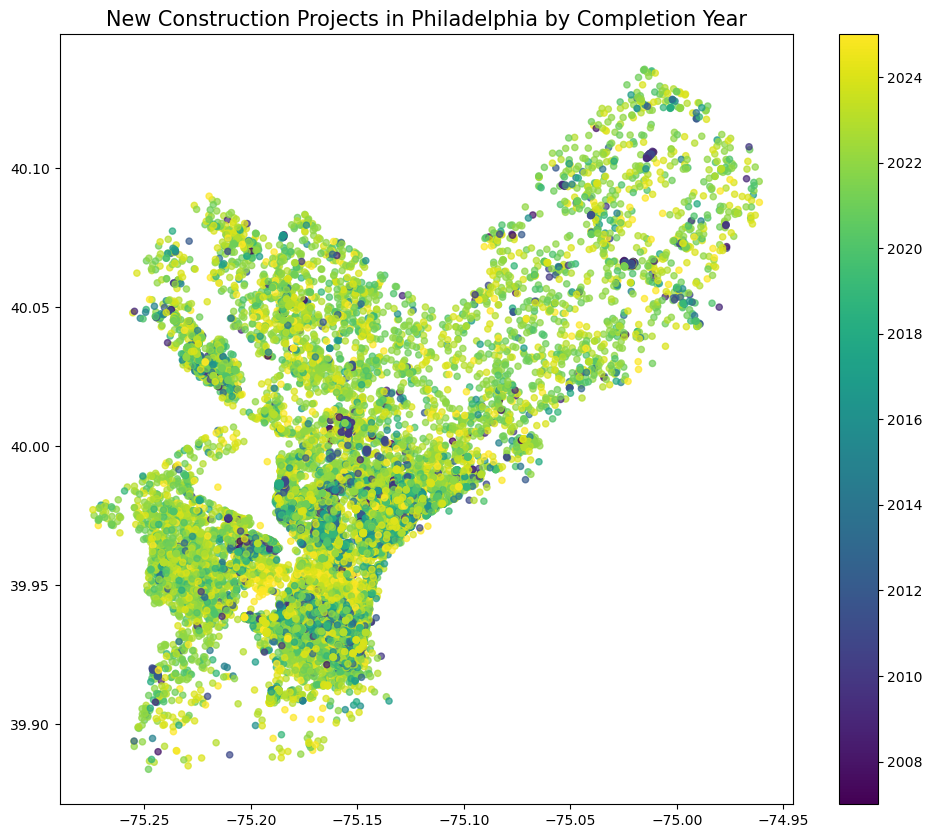

In [10]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

geo_subset = permits[['parcel_id_num', 'the_geom', 'permitcompleteddate']].drop_duplicates('parcel_id_num')
finishconssf = unitsbycompletion.merge(
    geo_subset[['parcel_id_num', 'the_geom']], 
    on='parcel_id_num', 
    how='left'
)

finishconssf['conscomplete'] = pd.to_datetime(finishconssf['conscomplete'], errors='coerce')
finishconssf['completion_year'] = finishconssf['conscomplete'].dt.year


gdf = gpd.GeoDataFrame(finishconssf,  geometry=gpd.GeoSeries.from_wkb(finishconssf["the_geom"]), crs=4326)


# Create the map
fig, ax = plt.subplots(figsize=(12, 10))

# Plot points colored by completion year
gdf.plot(
    column='completion_year',
    cmap='viridis',
    legend=True,
    ax=ax,
    markersize=20,
    alpha=0.7
)

# Add title and labels
plt.title('New Construction Projects in Philadelphia by Completion Year', fontsize=15)


Text(0.5, 1.0, 'New Construction Density in Philadelphia')

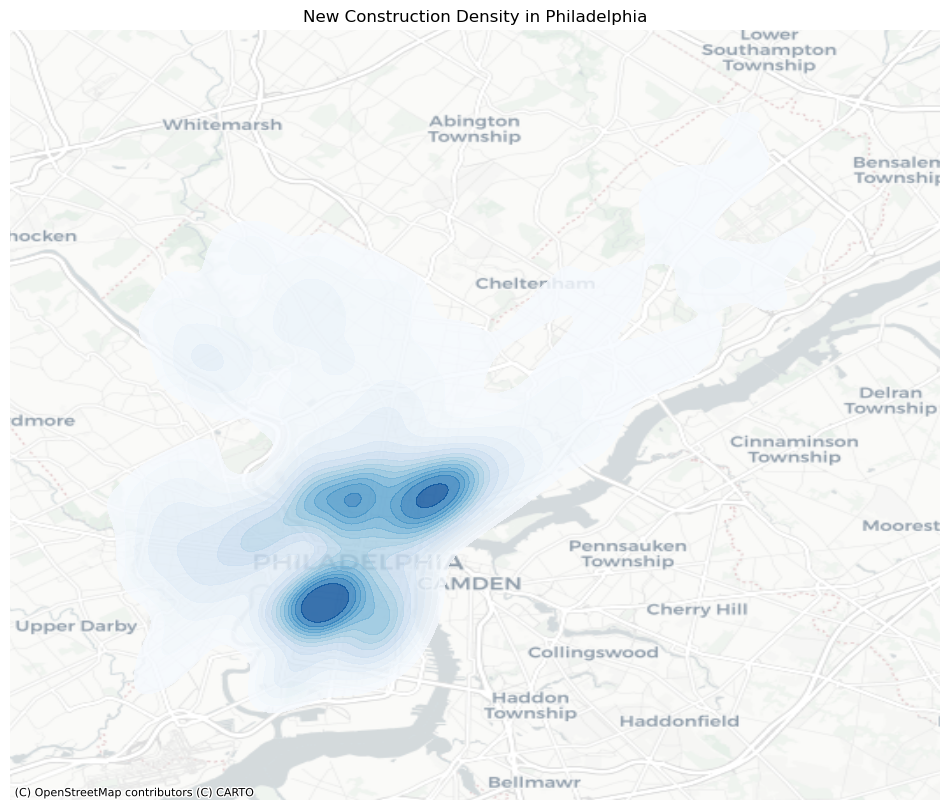

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import contextily as ctx

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

gdf_projected = gdf.to_crs('EPSG:3857')

# Get the coordinates for the KDE
x = gdf_projected.geometry.x
y = gdf_projected.geometry.y

# Create a custom colormap (from light to dark blue)
colors = ["#f7fbff", "#deebf7", "#c6dbef", "#9ecae1", "#6baed6", "#4292c6", "#2171b5", "#08519c", "#08306b"]
cmap = LinearSegmentedColormap.from_list("blue_density", colors)

# Create and plot the KDE
kde = sns.kdeplot(
    x=x, 
    y=y,
    fill=True,
    alpha=0.8,
    cmap=cmap,
    levels=15,
    thresh=0.05,
    ax=ax
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title('New Construction Density in Philadelphia')

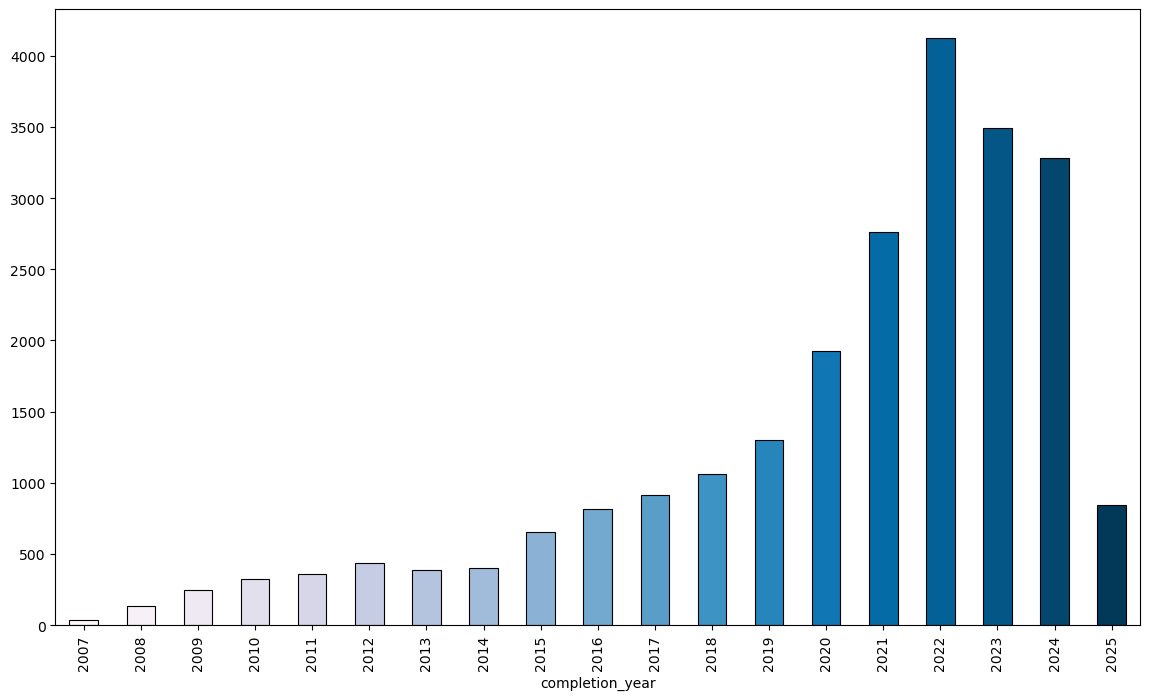

In [180]:
plt.figure(figsize=(14, 8))

# Count projects by year
yearly_counts = gdf.groupby('completion_year').size()

# Create color gradient for bars matching the map
year_colors = plt.cm.PuBu(np.linspace(0, 1, len(yearly_counts)))

# Plot with enhanced style
ax = yearly_counts.plot(
    kind='bar',
    color=year_colors,
    edgecolor='black',
    linewidth=0.8
)

In [161]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import imageio
from matplotlib.colors import Normalize
import os
from tqdm import tqdm

def create_construction_animation(gdf, output_filename='construction_by_year.gif', fps=1):
    # Get the range of years
    min_year = int(gdf['completion_year'].min())
    max_year = int(gdf['completion_year'].max())
    years = range(min_year, max_year + 1)
    
    # Create a directory for temporary image files
    temp_dir = 'temp_frames'
    os.makedirs(temp_dir, exist_ok=True)
    
    # Setup colormap normalization based on full year range
    norm = Normalize(vmin=min_year, vmax=max_year)
    
    # Create a frame for each year
    filenames = []
    
    for year in tqdm(years, desc="Generating frames"):
        # Create a new figure for each frame
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Plot the basemap/background (just the outline of all points)
        gdf.plot(color='lightgrey', ax=ax, markersize=10, alpha=0.2)
        
        # Plot points for the current year and all previous years
        year_mask = gdf['completion_year'] <= year
        current_gdf = gdf[year_mask]
        
        if not current_gdf.empty:
            current_gdf.plot(
                column='completion_year',
                cmap='viridis',
                norm=norm,  # Use the consistent normalization
                legend=True,
                ax=ax,
                markersize=20,
                alpha=0.7
            )
        
        # Add title with the current year
        plt.title(f'New Construction Projects in Philadelphia through {year}', fontsize=15)
        
        # Add a text annotation showing the current year prominently
        plt.annotate(f'Year: {year}', xy=(0.02, 0.05), xycoords='figure fraction', 
                     fontsize=16, fontweight='bold', color='black',
                     bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
        
        # Save the frame
        filename = f'{temp_dir}/frame_{year}.png'
        plt.savefig(filename, dpi=100, bbox_inches='tight')
        plt.close(fig)
        filenames.append(filename)
    
    # Create a GIF from the saved frames
    with imageio.get_writer(output_filename, mode='I', fps=fps, loop=0) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
    
    # Optional: Clean up temporary files
    for filename in filenames:
        os.remove(filename)
    os.rmdir(temp_dir)
    
    print(f"Animation saved as {output_filename}")
    return output_filename

# Example usage:
create_construction_animation(gdf, output_filename='philadelphia_construction.gif', fps=1)

Generating frames: 100%|██████████| 19/19 [00:30<00:00,  1.62s/it]
/var/folders/mm/m098rbs1529c7x072qh31ncw0000gn/T/ipykernel_22330/1070265410.py:64: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Animation saved as philadelphia_construction.gif


'philadelphia_construction.gif'

In [19]:
districts = gpd.read_file('https://opendata.arcgis.com/api/v3/datasets/1ba5a5d68f4a4c75806e78b1d9245924_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1')

In [190]:
cons_dist = gpd.sjoin(gdf, districts, how='left', predicate='intersects')
dist_cons = cons_dist.groupby('DISTRICT').size().reset_index(name='count')
dist_cons.head()

,DISTRICT,count
0,1,4038
1,10,729
2,2,4753
3,3,2273
4,4,1576


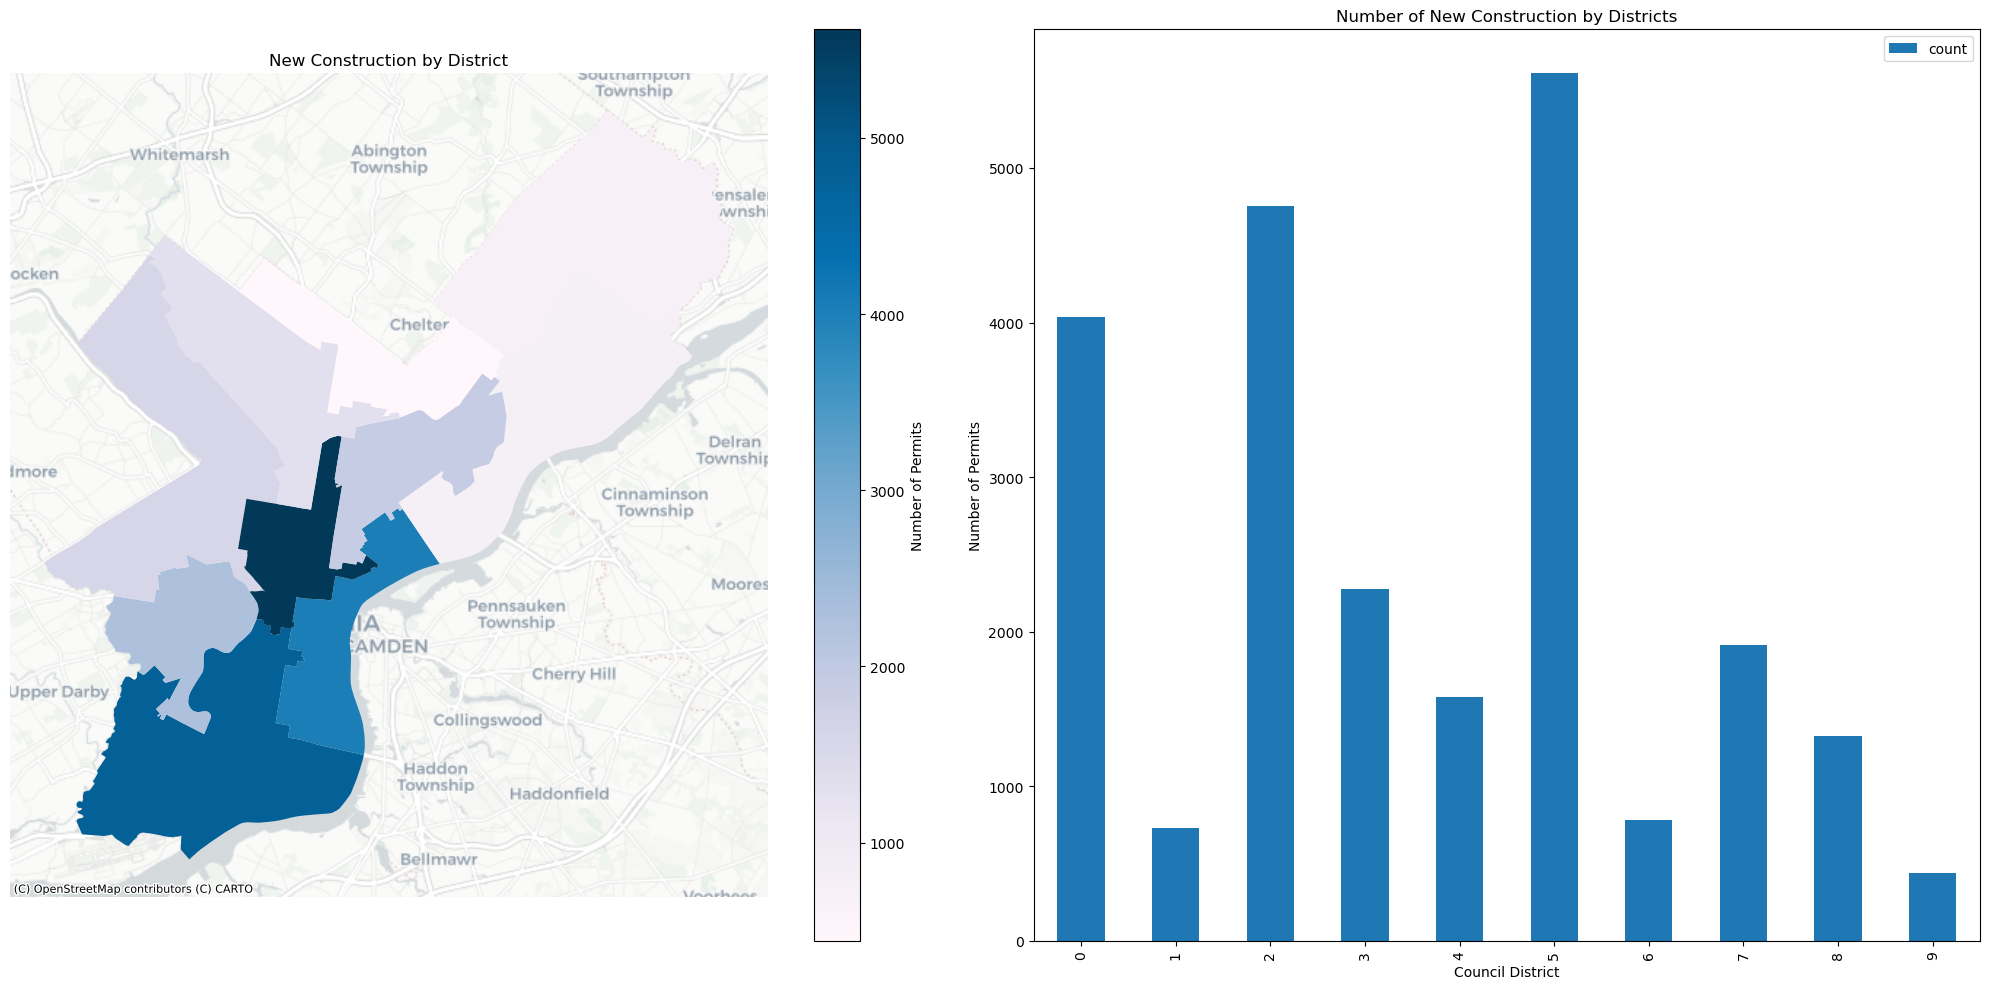

In [193]:
from shapely.geometry import Point
import contextily as ctx

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

merged_data = districts.merge(dist_cons, on='DISTRICT', how='left')
merged_data = merged_data.to_crs(epsg=3857)
merged_data.plot(column='count', 
                ax=ax1,
                legend=True,
                cmap='PuBu',
                legend_kwds={'label': 'Number of Permits'},
                missing_kwds={'color': 'lightgrey'})

# Basemap
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron)
ax1.set_axis_off()
ax1.set_title('New Construction by District')

# Bar chart of change of use permits by district
dist_cons.plot(kind='bar', ax=ax2)
ax2.set_title('Number of New Construction by Districts')
ax2.set_xlabel('Council District')
ax2.set_ylabel('Number of Permits')

plt.tight_layout()
plt.show()

## Adaptive Reuse

In [13]:
# Adaptive Reuse related words, entire structure work but no new construction
adaptwork = [
    'ENTSTR','ENTIRE'
]

# filerting
adaptconsprops = permits[
    permits['typeofwork'].isin(adaptwork)
]

In [15]:
adaptunits = permits[permits['parcel_id_num'].isin(newconsprops['parcel_id_num'])].groupby('parcel_id_num')['permitcompleteddate'].max().reset_index()
adaptunits = adaptunits.rename(columns={'permitcompleteddate': 'conscomplete'})
adaptunits.head()

,parcel_id_num,conscomplete
0,-888680028,2023-10-28T18:56:30Z
1,-888660469,2022-10-13T18:56:53Z
2,-888300924,2021-07-15T15:00:49Z
3,-888300920,2021-03-24T15:49:57Z
4,-888300804,2023-04-03T16:44:42Z


In [16]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

finishadapt = adaptunits.merge(
    geo_subset[['parcel_id_num', 'the_geom']], 
    on='parcel_id_num', 
    how='left'
)

finishadapt['conscomplete'] = pd.to_datetime(finishadapt['conscomplete'], errors='coerce')
finishadapt['completion_year'] = finishadapt['conscomplete'].dt.year


gdfadapt = gpd.GeoDataFrame(finishadapt,  geometry=gpd.GeoSeries.from_wkb(finishadapt["the_geom"]), crs=4326)

Text(0.5, 1.0, 'Adaptive Reuse Density in Philadelphia')

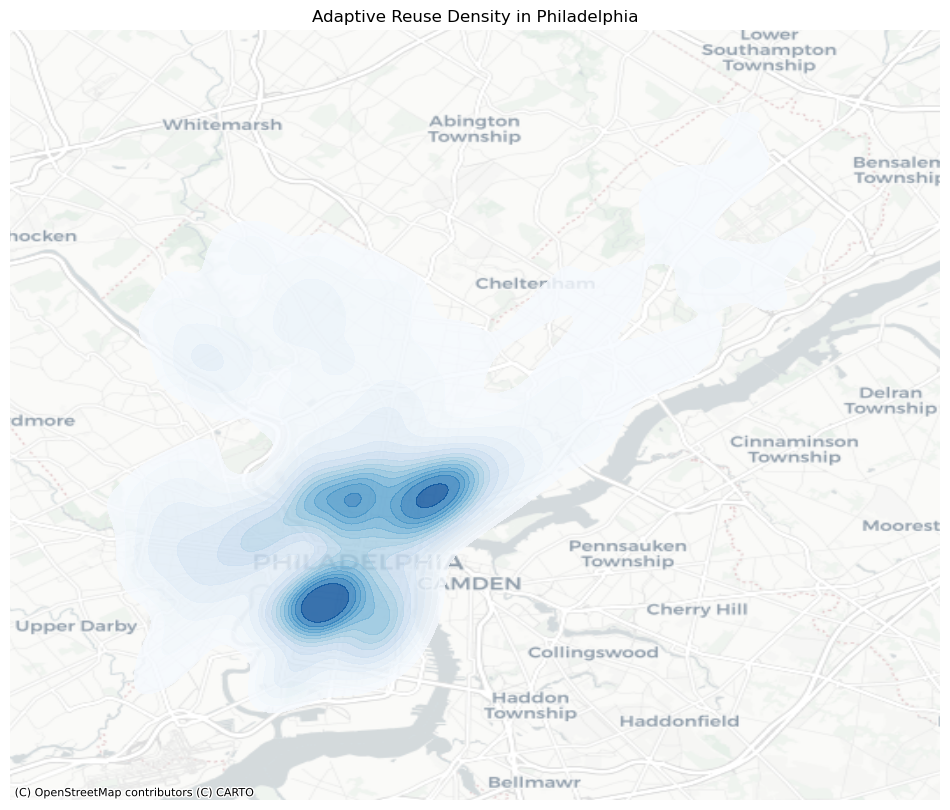

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import contextily as ctx

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

adaptprog = gdfadapt.to_crs('EPSG:3857')

# Get the coordinates for the KDE
x = adaptprog.geometry.x
y = adaptprog.geometry.y

# Create a custom colormap (from light to dark blue)
colors = ["#f7fbff", "#deebf7", "#c6dbef", "#9ecae1", "#6baed6", "#4292c6", "#2171b5", "#08519c", "#08306b"]
cmap = LinearSegmentedColormap.from_list("blue_density", colors)

# Create and plot the KDE
kde = sns.kdeplot(
    x=x, 
    y=y,
    fill=True,
    alpha=0.8,
    cmap=cmap,
    levels=15,
    thresh=0.05,
    ax=ax
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title('Adaptive Reuse Density in Philadelphia')

/opt/homebrew/Caskroom/mambaforge/base/envs/practicumenv/lib/python3.11/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 28 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


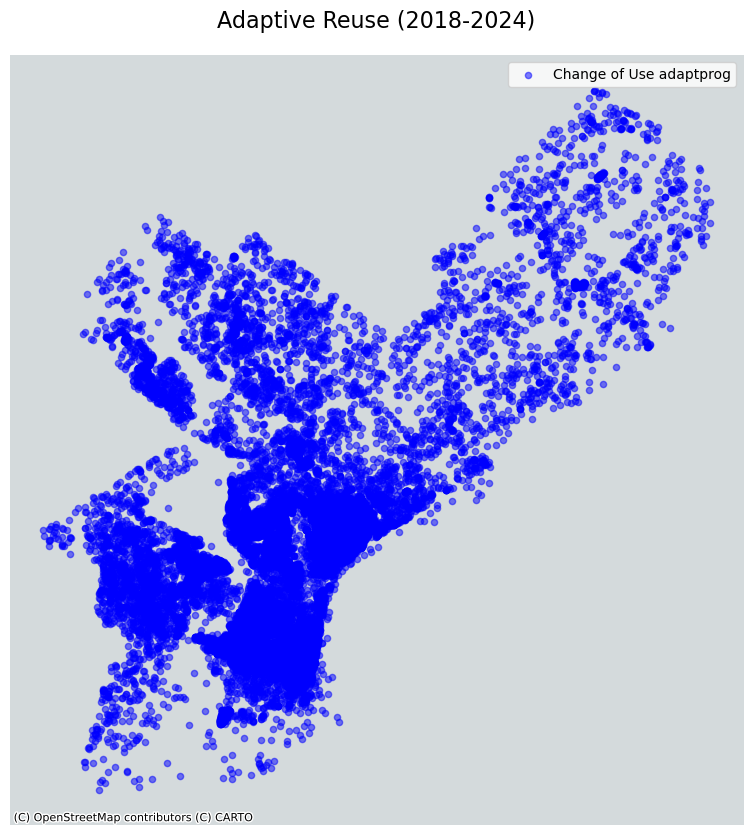

In [23]:
# Create a figure and axis first
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the adaptive reuse points
gdfadapt.plot(ax=ax, 
             alpha=0.5, 
             c='blue',
             markersize=20,
             label='Change of Use adaptprog')

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Plot customization
plt.title('Adaptive Reuse (2018-2024)', fontsize=16, pad=20)
ax.set_axis_off()
plt.legend()  # Add a legend for the blue points

plt.show()

Text(0.5, 1.0, 'Adaptive Reuse by District')

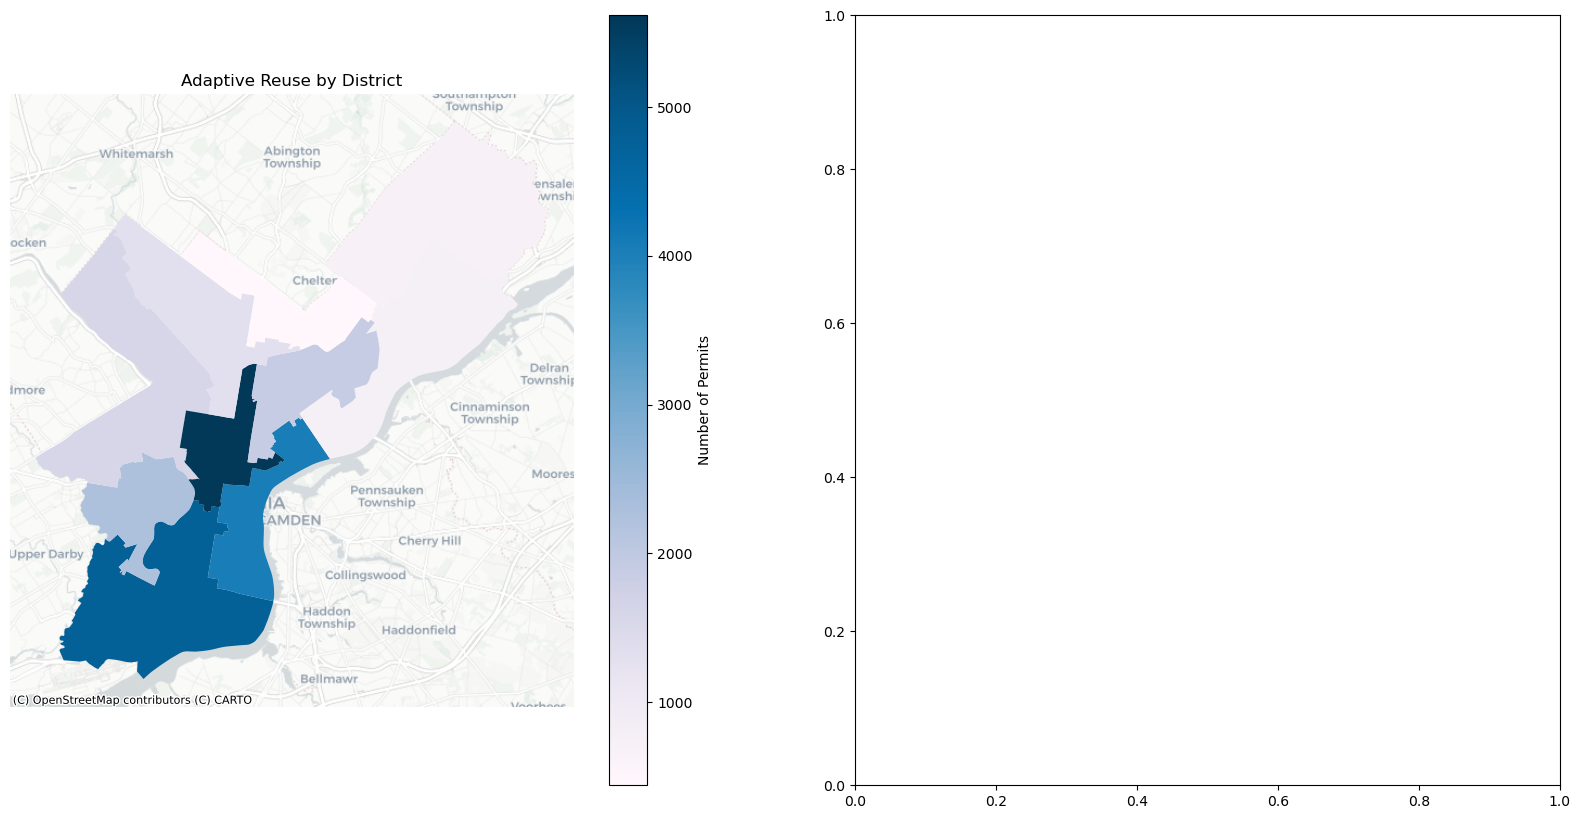

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

adaptdist = gpd.sjoin(gdfadapt, districts, how='left', predicate='intersects')
distadapt = adaptdist.groupby('DISTRICT').size().reset_index(name='count')

adaptmerge = districts.merge(distadapt, on='DISTRICT', how='left')

# Set the active geometry column after merging
adaptmerge = adaptmerge.set_geometry('geometry')  # Choose the appropriate geometry column

adaptmerge = adaptmerge.to_crs(epsg=3857)
adaptmerge.plot(column='count', 
                ax=ax1,
                legend=True,
                cmap='PuBu',
                legend_kwds={'label': 'Number of Permits'},
                missing_kwds={'color': 'lightgrey'})

# Basemap
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron)
ax1.set_axis_off()
ax1.set_title('Adaptive Reuse by District')